In [1]:
import matplotlib.pyplot as plt


from extract_WEST_data import extract_data

filename = "data/exposure_conditions_divertor/WEST/Hao/P1.0e21_wall_data.mat"
# filename = "data/exposure_conditions_divertor/WEST/Julien/WPN54696-1.5MW-FESTIM_inputs.csv"
R_div, Z_div, arc_length_div, E_ion_div, E_atom_div, ion_flux_div, \
        atom_flux_div, net_heat_flux_div, angles_ions, angles_atoms, data = extract_data(filename)

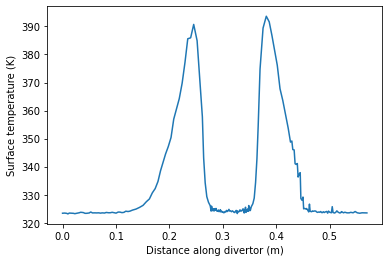

In [2]:
T = 1.1e-4*net_heat_flux_div + 323
plt.plot(arc_length_div, T)
xlabel = "Distance along divertor (m)"
plt.xlabel(xlabel)
plt.ylabel("Surface temperature (K)")
plt.show()

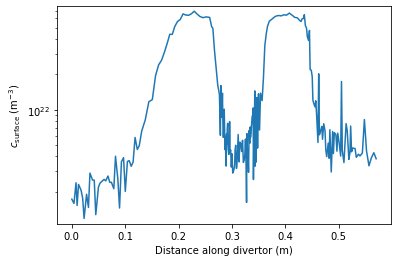

In [3]:
from compute_implantation_coefficients_angle import implantation_range, reflection_coeff
import numpy as np

def D(T):
    D_0_W = 1.9e-7
    E_D_W = 0.2
    return D_0_W*np.exp(-E_D_W/8.6e-5/T)

implantation_range_ions = [float(implantation_range(energy, angle)) for energy, angle in zip(E_ion_div, angles_ions)]  #1.4e-10 * E_ion_div**0.64
implantation_range_atoms = [float(implantation_range(energy, angle)) for energy, angle in zip(E_atom_div, angles_atoms)] # 1.4e-10 * E_atom_div**0.64

reflection_coeff_ions = np.array([float(reflection_coeff(energy, angle)) for energy, angle in zip(E_ion_div, angles_ions)])
reflection_coeff_atoms = np.array([float(reflection_coeff(energy, angle)) for energy, angle in zip(E_atom_div, angles_atoms)])
if "Julien" in filename:
    reflection_coeff_ions = 0
    reflection_coeff_atoms = 0

c_max = (1 - reflection_coeff_ions)*ion_flux_div*implantation_range_ions/D(T) + \
    (1 - reflection_coeff_atoms)*atom_flux_div*implantation_range_atoms/D(T)
plt.yscale("log")
plt.ylim(min(c_max)*0.9, max(c_max)*1.1)

plt.plot(arc_length_div, c_max)

plt.xlabel(xlabel)
plt.ylabel("$c_\mathrm{surface}$ (m$^{-3}$)")
plt.show()

In [4]:
from inventory_T_c import estimate_inventory_with_gp_regression
from scipy.interpolate import interp2d

inv, sig, points_x, points_y, sim_points = \
    estimate_inventory_with_gp_regression()

inv_T_c = interp2d(points_x, points_y, inv, kind='cubic')
sig_inv = interp2d(points_x, points_y, sig, kind='cubic')

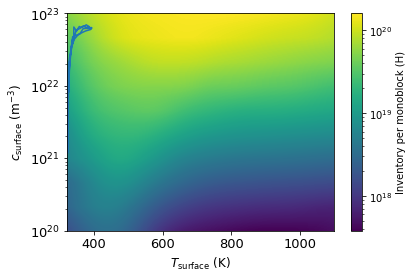

In [5]:
from matplotlib import ticker
XX, YY = np.meshgrid(points_x, points_y)

values = np.zeros(XX.shape)
for i in range(len(XX)):
    for j in range(len(XX[i])):
        if XX[i][j] < 1200:
            val = inv_T_c(XX[i][j], YY[i][j])
            values[i][j] = val
locator = ticker.LogLocator(base=10)
levels = np.logspace(
    min(np.log10(inv)),
    max(np.log10(inv)),
    1000)
CS = plt.contourf(XX, YY, values, locator=locator, levels=levels)
plt.plot(T, c_max)
plt.colorbar(CS, label=r"Inventory per monoblock (H)", ticks=locator)
plt.yscale("log")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel(r"$T_\mathrm{surface}$ (K)", fontsize=12)
plt.ylabel(r"$c_\mathrm{surface}$ (m$^{-3}$)", fontsize=12)
plt.show()

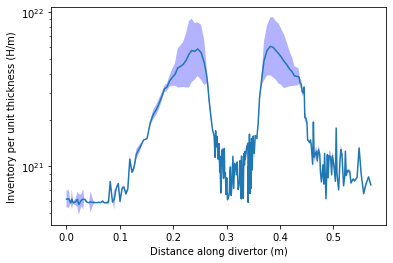

In [6]:
e = 12e-3  # monoblock thickness (m)
inventories = []  # inventory in H/m
for temperature, concentration in zip(T, c_max):
    inventories.append(float(inv_T_c(temperature, concentration))/e)
plt.plot(arc_length_div, inventories)
sigmas = np.array([float(sig_inv(temperature, concentration)) for temperature, concentration in zip(T, c_max)])

plt.fill_between(
    [float(x) for x in arc_length_div], 10**(2*sigmas + np.log10(inventories)), 10**(-2*sigmas + np.log10(inventories)),
    facecolor='blue', alpha=0.3)
plt.xlabel(xlabel)
plt.yscale("log")
plt.ylabel("Inventory per unit thickness (H/m)")
plt.savefig("Inventory per monoblock.pdf")
plt.show()